In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as mt
import matplotlib.pyplot as plt
import os

In [41]:
source_dir = "/home/vincent/Documenten/BachelorsProject/ots_scale/"
target_dir = "/home/vincent/Documenten/BachelorsProject/GitHub_Repo/results/ots_scale/"

# Training set size per dataset:
ds_sizes = {
    "100" : 6336,
    "056" : 3554,
    "032" : 1995,
    "018" : 1113,
    "010" : 624,
}

models = {
    "vit_b_16": {"vit": True},
    "swin_b": {"vit": True},
    "beit_b_16": {"vit": True},
    "deit_b_16": {"vit": True},
    "vgg19": {"vit": False},
    "resnet50": {"vit": False},
    "efficientnetv2_m": {"vit": False},
    "convnext_b": {"vit": False}
}

In [3]:
def getArrays(csv_predictions: str, csv_confusion: str):
    """Returns numpy arrays we can work with using scikit-learn"""
    df_pred = pd.read_csv(csv_predictions)
    df_conf = pd.read_csv(csv_confusion)

    true_y = df_pred["actual_idx"].to_numpy()
    pred_y = df_pred[df_conf.columns[1:]].to_numpy()

    # Rows gives actual, columns prediction
    conf = df_conf[df_conf.columns[1:]].to_numpy().T

    return true_y, pred_y, conf

In [24]:
def accFromCsv(csv_predictions):
    csv_confusion = csv_predictions.replace("predictions", "confusion")
    true_y, pred_y, _ = getArrays(csv_predictions, csv_confusion)
    pred_y_max = np.argmax(pred_y, axis=1)
    return { "acc": mt.accuracy_score(true_y, pred_y_max),
             "b_acc": mt.balanced_accuracy_score(true_y, pred_y_max),
             "top3_acc": mt.top_k_accuracy_score(true_y, pred_y, k=3),
             "top5_acc": mt.top_k_accuracy_score(true_y, pred_y, k=5)}

In [39]:
# Creating a long-form dataframe with all datapoints
df = pd.DataFrame(columns=["ds_num", "ds_size", "model", "acc", "b_acc", "top3_acc", "top5_acc"])

for file in os.scandir(source_dir):
    if file.is_file() and "test_predictions.csv" in file.name:
        row = accFromCsv(file.path)
        row["model"] = [m for m in models if m in file.name][0]
        row["ds_size"] = [s for s in ds_sizes if s in file.name][0]
        
        # Gave dataset0 different naming, so have to treat it different than 1 to 4
        if "_" + row["ds_size"] not in file.name:
            row["ds_num"] = 0
        else:
            s = "scale"
            row["ds_num"] = int(file.name[file.name.find(s) + len(s)])
        
        row["ds_size"] = int(row["ds_size"])

        row = pd.DataFrame(row, index=[0])
        df = pd.concat([df, row], ignore_index=True)

df.sort_values(["ds_num", "ds_size", "model"], inplace=True, ignore_index=True)
df

,ds_num,ds_size,model,acc,b_acc,top3_acc,top5_acc
0,0,10,beit_b_16,0.73494,0.688889,0.927711,0.975904
1,0,10,convnext_b,0.855422,0.868889,0.987952,1.0
2,0,10,deit_b_16,0.855422,0.843333,0.975904,1.0
3,0,10,efficientnetv2_m,0.650602,0.653333,0.903614,0.963855
4,0,10,resnet50,0.831325,0.82,0.963855,0.975904
...,...,...,...,...,...,...,...
195,4,100,efficientnetv2_m,0.818068,0.822494,0.97867,0.997491
196,4,100,resnet50,0.898369,0.890718,0.994981,0.998745
197,4,100,swin_b,0.915935,0.902134,0.996236,1.0
198,4,100,vgg19,0.865747,0.871188,0.991217,1.0


In [42]:
df.to_csv(os.path.join(target_dir, "all_results.csv"), index=False)

In [56]:
for model in models:
    for size in ds_sizes:
        tmpDf = df[(df.model == model) & (df.ds_size == int(size))]
        models[model][size] = {
            "acc_mean": tmpDf["acc"].mean(),
            "acc_std": tmpDf["acc"].std(),
            "b_acc_mean": tmpDf["b_acc"].mean(),
            "b_acc_std": tmpDf["b_acc"].std()
        }
        models[model][size]["acc_top"] = models[model][size]["acc_mean"] +\
            models[model][size]["acc_std"] / len(tmpDf) ** .5
        models[model][size]["acc_bottom"] = models[model][size]["acc_mean"] -\
            models[model][size]["acc_std"] / len(tmpDf) ** .5

In [22]:
prediction_files = []

for file in os.scandir(source_dir):
    if file.is_file() and "test_predictions.csv" in file.name:
        prediction_files += [file]

for key in ds_sizes:
    for file in [x for x in prediction_files if key in x.name]:
        for model in models:
            if model in file.name:
                if key in models[model]:
                    models[model][key] += [accFromCsv(file.path)]
                else:
                    models[model][key] = [accFromCsv(file.path)]
                break

In [50]:
import pprint
pprint.pprint(models)

{'beit_b_16': {'010': {'acc': 0.7180722891566265},
               '018': {'acc': 0.7438356164383562},
               '032': {'acc': 0.8},
               '056': {'acc': 0.8295154185022027},
               '100': {'acc': 0.8577164366373902},
               'vit': True},
 'convnext_b': {'010': {'acc': 0.8240963855421686},
                '018': {'acc': 0.8397260273972602},
                '032': {'acc': 0.87421875},
                '056': {'acc': 0.8885462555066079},
                '100': {'acc': 0.9048933500627353},
                'vit': False},
 'deit_b_16': {'010': {'acc': 0.8337349397590362},
               '018': {'acc': 0.8315068493150685},
               '032': {'acc': 0.87578125},
               '056': {'acc': 0.8762114537444935},
               '100': {'acc': 0.8983688833124216},
               'vit': True},
 'efficientnetv2_m': {'010': {'acc': 0.7156626506024096},
                      '018': {'acc': 0.747945205479452},
                      '032': {'acc': 0.76796875},
       

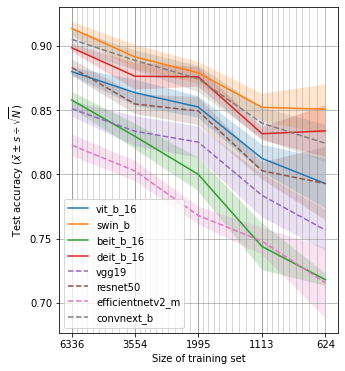

In [58]:
keys = [key for key in ds_sizes]
x = [ds_sizes[key] for key in keys]

num_interp_points = 10
for idx in range(len(x) - 1):
    interp = np.linspace(x[idx], x[idx+1], num_interp_points, endpoint=False)
    for p in interp:
        plt.axvline(p, color='black', alpha=0.3, linewidth=0.5)

for model in models:
    y = [models[model][key]["acc_mean"] for key in keys]
    ytop = [models[model][key]["acc_top"] for key in keys]
    ybott = [models[model][key]["acc_bottom"] for key in keys]
    ls = "-" if models[model]["vit"] else "--"
    plt.plot(x, y, label=model, linestyle=ls)
    plt.fill_between(x, y1=ybott, y2=ytop, alpha=0.2)

plt.legend()
plt.grid()
plt.xlabel("Size of training set")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.minorticks_off()

plt.xticks(x, [str(idx) for idx in x])

plt.ylabel(r"Test accuracy ($\bar{x} \pm s \div \sqrt{N}$)")

fig = plt.gcf()
fig.set_size_inches(5, 6)

plt.show()